Silhouette por k: {2: 0.22468711623046456, 3: 0.20886406076087474, 4: 0.13867050081581242, 5: 0.08357732713659774, 6: 0.0826982344731324, 7: 0.08197588039947656}
Usando k = 3 clusters (forzado)


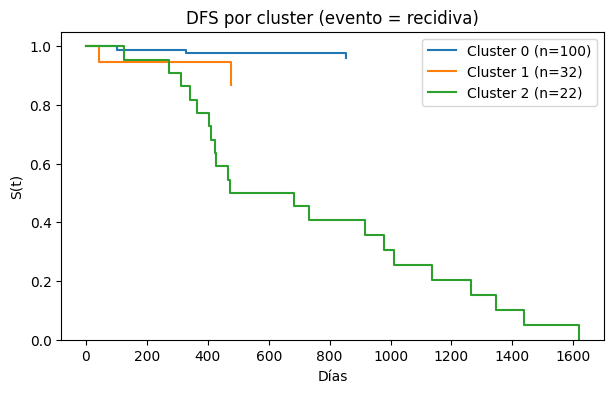

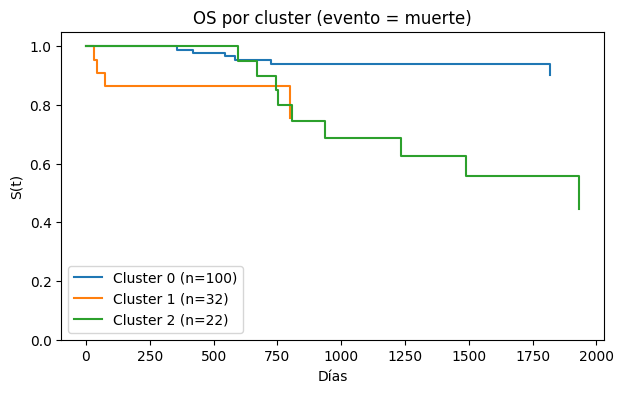

Log-rank DFS: chi2=119.741, p=0.000e+00
Log-rank OS : chi2=16.140, p=3.127e-04


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.stats import chi2

df = pd.read_csv("bbdd_imputed_final.csv")

def to_date(x):
    if pd.isna(x):
        return pd.NaT
    s = str(x).strip()
    if s in {"0", "0.0", ""}:
        return pd.NaT
    return pd.to_datetime(s, errors="coerce")

for c in ["f_diag", "fecha_qx", "visita_control", "f_muerte"]:
    if c in df.columns:
        df[c] = df[c].apply(to_date)

df["OS_event"] = np.where(
    df["f_muerte"].notna(), 1,
    np.where(df["Exitus"].isin([0, 1]), df["Exitus"], np.nan)
)

df["OS_time"] = np.where(
    df["OS_event"] == 1,
    (df["f_muerte"] - df["fecha_qx"]).dt.days,
    np.where(
        df["OS_event"] == 0,
        (df["visita_control"] - df["fecha_qx"]).dt.days,
        np.nan
    )
)

df["DFS_event"] = np.where(df["recidiva"].isin([0, 1]), df["recidiva"], np.nan)

end_follow = df["visita_control"].copy()
mask_death_no_rec = (df["DFS_event"] == 0) & (df["f_muerte"].notna()) & (df["fecha_qx"].notna())
end_follow.loc[mask_death_no_rec] = df.loc[mask_death_no_rec, "f_muerte"]

df["DFS_time"] = np.where(
    df["DFS_event"] == 1,
    df["DFS"],
    np.where(
        df["DFS_event"] == 0,
        (end_follow - df["fecha_qx"]).dt.days,
        np.nan
    )
)

df.loc[df["OS_time"] < 0, "OS_time"] = np.nan
df.loc[df["DFS_time"] < 0, "DFS_time"] = np.nan

leak_cols = [
    "recidiva", "Exitus", "numero_de_recid", "dx_recidiva", "num_recidiva",
    "Tt_recidiva_qx", "visita_control", "f_muerte", "f_diag", "fecha_qx",
    "est_pcte", "libre_enferm"
]
feat_cols = [c for c in df.columns if c not in leak_cols]
X = df[feat_cols].copy()

num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
    ],
    remainder="drop"
)

Xt = preprocess.fit_transform(X)
if hasattr(Xt, "toarray"):
    Xt = Xt.toarray()

sil = {}
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(Xt)
    sil[k] = silhouette_score(Xt, labels)

best_k = 3
print("Silhouette por k:", sil)
print("Usando k =", best_k, "clusters (forzado)")

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df["cluster"] = kmeans.fit_predict(Xt)

def km_estimator(time, event):
    d = pd.DataFrame({"time": time, "event": event}).dropna()
    d = d[d["time"] >= 0].sort_values("time")

    event_times = np.sort(d.loc[d["event"] == 1, "time"].unique())
    surv = 1.0
    rows = []

    for t in event_times:
        at_risk = (d["time"] >= t).sum()
        d_events = ((d["time"] == t) & (d["event"] == 1)).sum()
        surv *= (1 - d_events / at_risk)
        rows.append((t, surv))

    return pd.DataFrame(rows, columns=["time", "survival"])

def plot_km(ax, time, event, label):
    km = km_estimator(time, event)
    xs = [0] + km["time"].tolist()
    ys = [1.0] + km["survival"].tolist()
    ax.step(xs, ys, where="post", label=label)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel("Días")
    ax.set_ylabel("S(t)")

def multivariate_logrank(time, event, groups):
    d = pd.DataFrame({"time": time, "event": event, "group": groups}).dropna()
    d = d[d["time"] >= 0]

    event_times = np.sort(d.loc[d["event"] == 1, "time"].unique())
    groups_u = sorted(d["group"].unique())
    k = len(groups_u)

    O = np.zeros(k)
    E = np.zeros(k)
    V = np.zeros((k, k))

    for t in event_times:
        at_risk = d[d["time"] >= t]
        d_events = d[(d["time"] == t) & (d["event"] == 1)]
        n_tot = len(at_risk)
        d_tot = len(d_events)
        if n_tot <= 1 or d_tot == 0:
            continue

        n_g = np.array([(at_risk["group"] == g).sum() for g in groups_u], dtype=float)
        d_g = np.array([(d_events["group"] == g).sum() for g in groups_u], dtype=float)
        e_g = d_tot * n_g / n_tot

        O += d_g
        E += e_g

        factor = d_tot * (n_tot - d_tot) / (n_tot**2 * (n_tot - 1))
        for i in range(k):
            V[i, i] += factor * n_g[i] * (n_tot - n_g[i])
            for j in range(k):
                if i != j:
                    V[i, j] += -factor * n_g[i] * n_g[j]

    Z = (O - E)[:k-1]
    V_red = V[:k-1, :k-1]
    chi2_stat = float(Z.T @ np.linalg.pinv(V_red) @ Z)
    p = float(1 - chi2.cdf(chi2_stat, df=k-1))
    return chi2_stat, p

def km_by_cluster(df, time_col, event_col, title):
    fig, ax = plt.subplots(figsize=(7, 4))
    for c in sorted(df["cluster"].unique()):
        sub = df[df["cluster"] == c]
        plot_km(ax, sub[time_col], sub[event_col], label=f"Cluster {c} (n={len(sub)})")
    ax.legend()
    ax.set_title(title)
    plt.show()

km_by_cluster(df, "DFS_time", "DFS_event", "DFS por cluster (evento = recidiva)")
km_by_cluster(df, "OS_time",  "OS_event",  "OS por cluster (evento = muerte)")

chi2_dfs, p_dfs = multivariate_logrank(df["DFS_time"], df["DFS_event"], df["cluster"])
chi2_os,  p_os  = multivariate_logrank(df["OS_time"],  df["OS_event"],  df["cluster"])
print(f"Log-rank DFS: chi2={chi2_dfs:.3f}, p={p_dfs:.3e}")
print(f"Log-rank OS : chi2={chi2_os:.3f}, p={p_os:.3e}")

df.to_csv("dataset_con_clusters_y_endpoints.csv", index=False)


# Evaluación de Estrategias de Clustering

In [2]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

print("="*60)
print("EVALUACIÓN DE ESTRATEGIAS DE CLUSTERING")
print("="*60)

estrategias = {
    "Solo_Demograficas": ["edad", "imc", "asa"],
    "Solo_Tumorales": ["tamano_tumoral", "Grado", "tipo_histologico", 
                       "infiltracion_mi", "afectacion_linf"],
    "Solo_Molecular": ["recep_est_porcent", "rece_de_Ppor"], 
    "Demograficas_Molecular": ["edad", "imc", "asa", 
                               "recep_est_porcent", "rece_de_Ppor"],
    "Tumorales_Molecular": ["tamano_tumoral", "Grado", "tipo_histologico",
                            "infiltracion_mi", "afectacion_linf",
                            "recep_est_porcent", "rece_de_Ppor"],
    "Demograficas_Tumorales": ["edad", "imc", "asa",
                               "tamano_tumoral", "Grado", "infiltracion_mi", 
                               "afectacion_linf"],
    "Riesgo_Clasico": ["edad", "imc", "Grado", "infiltracion_mi", 
                       "afectacion_linf", "tipo_histologico"],
    "Perfil_Moderno": ["ecotv_infiltsub", "ecotv_infiltobj", 
                       "recep_est_porcent", "rece_de_Ppor"],
    "Modelo_Integrado": ["edad", "imc", "tamano_tumoral", "Grado", 
                         "infiltracion_mi", "afectacion_linf",
                         "recep_est_porcent"],
    "Todas_Relevantes": ["edad", "imc", "Grado", "tipo_histologico",
                         "ecotv_infiltsub", "ecotv_infiltobj", "infiltracion_mi", 
                         "afectacion_linf", "recep_est_porcent", "rece_de_Ppor"]
}

resultados_estrategias = []

for nombre, variables in estrategias.items():
    vars_disponibles = [v for v in variables if v in df.columns]
    
    if len(vars_disponibles) < 2:
        continue
    
    X_temp = df[vars_disponibles].copy()
    num_temp = X_temp.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_temp = X_temp.select_dtypes(include=["object", "category"]).columns.tolist()
    
    prep_temp = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler())
            ]), num_temp),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("onehot", OneHotEncoder(handle_unknown="ignore"))
            ]), cat_temp)
        ],
        remainder="drop"
    )
    
    try:
        Xt_temp = prep_temp.fit_transform(X_temp)
        if hasattr(Xt_temp, "toarray"):
            Xt_temp = Xt_temp.toarray()
    except Exception as e:
        continue
    
    for k in range(2, 7):
        km_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_temp = km_temp.fit_predict(Xt_temp)
        
        try:
            sil_score = silhouette_score(Xt_temp, labels_temp)
            db_score = davies_bouldin_score(Xt_temp, labels_temp)
            ch_score = calinski_harabasz_score(Xt_temp, labels_temp)
            
            resultados_estrategias.append({
                "Estrategia": nombre,
                "Variables_N": len(vars_disponibles),
                "K_Clusters": k,
                "Silhouette": round(sil_score, 4),
                "Davies_Bouldin": round(db_score, 4),
                "Calinski_Harabasz": round(ch_score, 2)
            })
        except ValueError:
            pass

if resultados_estrategias:
    df_resultados = pd.DataFrame(resultados_estrategias)
    df_resultados = df_resultados.sort_values(by="Silhouette", ascending=False)
    
    print("\n" + "="*80)
    print("RESULTADOS COMPARATIVOS (Ordenados por Silhouette Score)")
    print("="*80)
    print(df_resultados.to_string(index=False))
    
    df_resultados.to_csv("comparacion_estrategias_endometrio.csv", index=False)
    
    mejor_estrategia = df_resultados.iloc[0]
    print("\n" + "*"*60)
    print(f"RECOMENDACIÓN: Estrategia '{mejor_estrategia['Estrategia']}' con K = {int(mejor_estrategia['K_Clusters'])} clusters")
    print("*"*60)


EVALUACIÓN DE ESTRATEGIAS DE CLUSTERING

RESULTADOS COMPARATIVOS (Ordenados por Silhouette Score)
            Estrategia  Variables_N  K_Clusters  Silhouette  Davies_Bouldin  Calinski_Harabasz
        Solo_Molecular            2           6      0.6515          0.5827             318.58
        Solo_Molecular            2           5      0.6429          0.5512             295.59
        Solo_Molecular            2           2      0.6122          0.7481             159.85
        Solo_Molecular            2           4      0.6087          0.6124             228.01
        Solo_Molecular            2           3      0.5472          0.6330             206.32
     Solo_Demograficas            3           2      0.5333          0.7204              65.27
        Solo_Tumorales            5           3      0.5082          0.9573              83.74
        Solo_Tumorales            5           2      0.4855          1.1705              71.18
        Solo_Tumorales            5           6

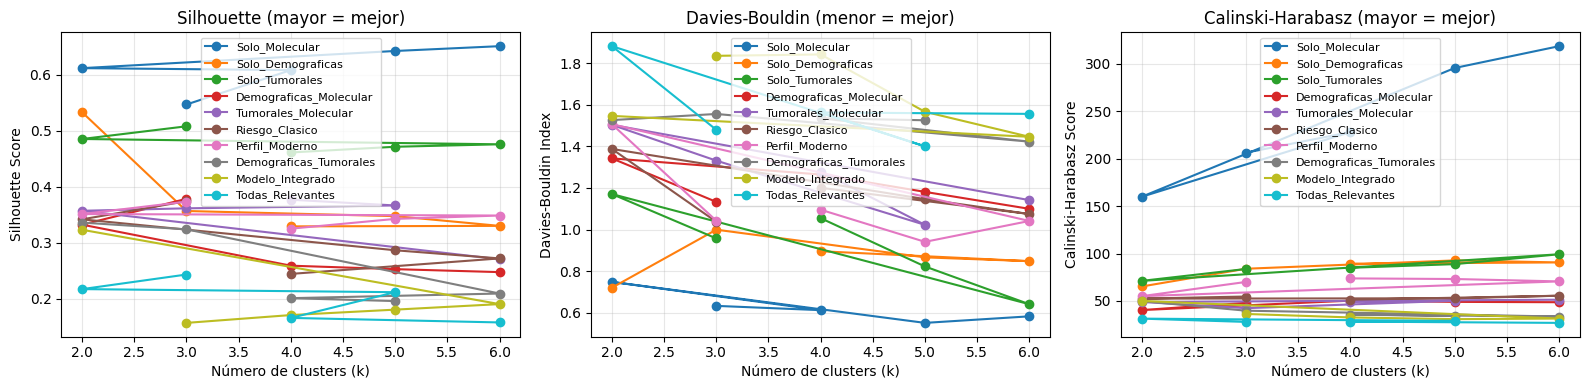

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for estrategia in df_resultados["Estrategia"].unique():
    data = df_resultados[df_resultados["Estrategia"] == estrategia]
    axes[0].plot(data["K_Clusters"], data["Silhouette"], marker='o', label=estrategia)
axes[0].set_xlabel("Número de clusters (k)")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette (mayor = mejor)")
axes[0].legend(fontsize=8)
axes[0].grid(alpha=0.3)

for estrategia in df_resultados["Estrategia"].unique():
    data = df_resultados[df_resultados["Estrategia"] == estrategia]
    axes[1].plot(data["K_Clusters"], data["Davies_Bouldin"], marker='o', label=estrategia)
axes[1].set_xlabel("Número de clusters (k)")
axes[1].set_ylabel("Davies-Bouldin Index")
axes[1].set_title("Davies-Bouldin (menor = mejor)")
axes[1].legend(fontsize=8)
axes[1].grid(alpha=0.3)

for estrategia in df_resultados["Estrategia"].unique():
    data = df_resultados[df_resultados["Estrategia"] == estrategia]
    axes[2].plot(data["K_Clusters"], data["Calinski_Harabasz"], marker='o', label=estrategia)
axes[2].set_xlabel("Número de clusters (k)")
axes[2].set_ylabel("Calinski-Harabasz Score")
axes[2].set_title("Calinski-Harabasz (mayor = mejor)")
axes[2].legend(fontsize=8)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis Detallado por Cluster

In [4]:
print("="*80)
print("ANÁLISIS DEMOGRÁFICO Y CLÍNICO POR CLUSTER")
print("="*80)

variables_interes = {
    "Demografía": ["edad", "imc", "asa"],
    "Características del Tumor": ["tamano_tumoral", "tipo_histologico", "Grado", 
                                  "FIGO2023", "grupo_de_riesgo_definitivo"],
    "Invasión y Extensión": ["infiltracion_mi", "afectacion_linf", "metasta_distan", 
                             "ecotv_infiltobj"],
    "Perfil Molecular": ["recep_est_porcent", "rece_de_Ppor"],
    "Tratamientos": ["tto_1_quirugico", "Tributaria_a_Radioterapia", "bqt", "qt"]
}

analisis_clusters = []

for cluster_id in sorted(df["cluster"].unique()):
    cluster_data = df[df["cluster"] == cluster_id]
    n = len(cluster_data)
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} (n={n}, {100*n/len(df):.1f}%)")
    print(f"{'='*80}")
    
    for categoria, vars_list in variables_interes.items():
        print(f"\n{categoria}:")
        print("-" * 40)
        
        for var in vars_list:
            if var not in df.columns:
                continue
            
            if df[var].dtype in ['int64', 'float64'] and len(df[var].unique()) > 5:
                valores = cluster_data[var].dropna()
                if len(valores) > 0:
                    media = valores.mean()
                    std = valores.std()
                    mediana = valores.median()
                    print(f"  {var}: {media:.2f} ± {std:.2f} (Mediana={mediana:.1f})")
                    
                    analisis_clusters.append({
                        "Cluster": cluster_id,
                        "Categoria": categoria,
                        "Variable": var,
                        "Tipo": "numerica",
                        "Valor": f"{media:.2f} ± {std:.2f}"
                    })
            else:
                counts = cluster_data[var].value_counts().sort_index()
                total = cluster_data[var].notna().sum()
                print(f"  {var}:")
                for valor, count in counts.items():
                    pct = 100 * count / total if total > 0 else 0
                    print(f"    - {valor}: {count} ({pct:.1f}%)")
                    
                    analisis_clusters.append({
                        "Cluster": cluster_id,
                        "Categoria": categoria,
                        "Variable": var,
                        "Tipo": "categorica",
                        "Valor": f"{valor}: {count} ({pct:.1f}%)"
                    })

df_analisis = pd.DataFrame(analisis_clusters)
df_analisis.to_csv("analisis_clusters_endometrio.csv", index=False)


ANÁLISIS DEMOGRÁFICO Y CLÍNICO POR CLUSTER

CLUSTER 0 (n=100, 64.9%)

Demografía:
----------------------------------------
  edad: 60.25 ± 13.32 (Mediana=59.0)
  imc: 32.45 ± 7.70 (Mediana=31.1)
  asa:
    - 0.0: 8 (8.0%)
    - 1.0: 69 (69.0%)
    - 2.0: 22 (22.0%)
    - 6.0: 1 (1.0%)

Características del Tumor:
----------------------------------------
  tamano_tumoral: 2.92 ± 2.55 (Mediana=2.2)
  tipo_histologico: 3.78 ± 12.17 (Mediana=2.0)
  Grado:
    - 1: 98 (98.0%)
    - 2: 2 (2.0%)
  FIGO2023: 1.47 ± 1.41 (Mediana=1.0)
  grupo_de_riesgo_definitivo: 1.12 ± 0.50 (Mediana=1.0)

Invasión y Extensión:
----------------------------------------
  infiltracion_mi:
    - 0.0: 34 (34.0%)
    - 1.0: 55 (55.0%)
    - 2.0: 11 (11.0%)
  afectacion_linf:
    - 0.0: 96 (96.0%)
    - 1.0: 4 (4.0%)
  metasta_distan:
    - 0.0: 100 (100.0%)
  ecotv_infiltobj:
    - 1.0: 11 (11.0%)
    - 2.0: 20 (20.0%)
    - 3.0: 5 (5.0%)
    - 4.0: 64 (64.0%)

Perfil Molecular:
-------------------------------------

In [5]:
from scipy.stats import f_oneway, kruskal, mannwhitneyu, chi2_contingency, shapiro
from itertools import combinations

print("\n" + "="*80)
print("COMPARACIÓN ESTADÍSTICA ENTRE CLUSTERS")
print("="*80)

vars_numericas = ["edad", "diametro_AAA"]
vars_numericas = [v for v in vars_numericas if v in df.columns]

pruebas_estadisticas = []

for var in vars_numericas:
    grupos = [df[df["cluster"] == c][var].dropna() for c in sorted(df["cluster"].unique())]
    grupos = [g for g in grupos if len(g) > 0]
    
    if len(grupos) < 2:
        continue
    
    normalidad = []
    for i, g in enumerate(grupos):
        if len(g) >= 3 and len(g) < 50:
            stat, p = shapiro(g)
            normalidad.append(p > 0.05)
        else:
            normalidad.append(None)
    
    if all([n is not False for n in normalidad if n is not None]):
        stat, p_val = f_oneway(*grupos)
        test_usado = "ANOVA"
    else:
        stat, p_val = kruskal(*grupos)
        test_usado = "Kruskal-Wallis"
    
    print(f"\n{var}:")
    print(f"  Test: {test_usado}")
    print(f"  Estadístico: {stat:.4f}")
    print(f"  p-valor: {p_val:.4e}")
    print(f"  Significativo: {'SÍ' if p_val < 0.05 else 'NO'} (alpha=0.05)")
    
    if p_val < 0.05 and len(grupos) > 2:
        print(f"  Comparaciones post-hoc (Mann-Whitney U):")
        cluster_ids = sorted(df["cluster"].unique())
        for i, j in combinations(range(len(cluster_ids)), 2):
            if len(grupos[i]) > 0 and len(grupos[j]) > 0:
                stat_mw, p_mw = mannwhitneyu(grupos[i], grupos[j], alternative='two-sided')
                sig = "Sí" if p_mw < 0.05 else "No"
                print(f"    Cluster {cluster_ids[i]} vs {cluster_ids[j]}: p={p_mw:.4f} ({sig})")
    
    pruebas_estadisticas.append({
        "Variable": var,
        "Test": test_usado,
        "Estadistico": stat,
        "p_valor": p_val,
        "Significativo": p_val < 0.05
    })

vars_categoricas = ["Sexo", "ASA", "Tipo_AAA", "HTA", "DM", "EPOC", "Tabaco"]
vars_categoricas = [v for v in vars_categoricas if v in df.columns]

for var in vars_categoricas:
    contingency = pd.crosstab(df["cluster"], df[var])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency)
    
    print(f"\n{var}:")
    print(f"  Test: Chi-cuadrado")
    print(f"  Estadístico: {chi2_stat:.4f}")
    print(f"  p-valor: {p_val:.4e}")
    print(f"  Grados de libertad: {dof}")
    print(f"  Significativo: {'SÍ' if p_val < 0.05 else 'NO'} (alpha=0.05)")
    print(f"  Tabla de contingencia:")
    print(contingency.to_string())
    
    pruebas_estadisticas.append({
        "Variable": var,
        "Test": "Chi-cuadrado",
        "Estadistico": chi2_stat,
        "p_valor": p_val,
        "Significativo": p_val < 0.05
    })

df_pruebas = pd.DataFrame(pruebas_estadisticas)
df_pruebas.to_csv("pruebas_estadisticas_clusters.csv", index=False)



COMPARACIÓN ESTADÍSTICA ENTRE CLUSTERS

edad:
  Test: ANOVA
  Estadístico: 1.9226
  p-valor: 1.4978e-01
  Significativo: NO (alpha=0.05)


In [6]:
print("\n" + "="*80)
print("ANÁLISIS DE SUPERVIVENCIA POR CLUSTER")
print("="*80)

supervivencia_clusters = []

for cluster_id in sorted(df["cluster"].unique()):
    cluster_data = df[df["cluster"] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")
    
    dfs_data = cluster_data[["DFS_time", "DFS_event"]].dropna()
    if len(dfs_data) > 0:
        n_dfs = len(dfs_data)
        eventos_dfs = dfs_data["DFS_event"].sum()
        tasa_recidiva = 100 * eventos_dfs / n_dfs
        tiempo_mediano_dfs = dfs_data["DFS_time"].median()
        
        km_dfs = km_estimator(dfs_data["DFS_time"], dfs_data["DFS_event"])
        
        def surv_at_time(km_df, t):
            if len(km_df) == 0:
                return np.nan
            earlier = km_df[km_df["time"] <= t]
            if len(earlier) == 0:
                return 1.0
            return earlier.iloc[-1]["survival"]
        
        s_1yr = surv_at_time(km_dfs, 365)
        s_2yr = surv_at_time(km_dfs, 730)
        s_3yr = surv_at_time(km_dfs, 1095)
        
        print(f"\nDFS (Disease-Free Survival):")
        print(f"  N válidos: {n_dfs}")
        print(f"  Eventos (recidiva): {int(eventos_dfs)} ({tasa_recidiva:.1f}%)")
        print(f"  Tiempo mediano: {tiempo_mediano_dfs:.1f} días")
        print(f"  Supervivencia libre de enfermedad:")
        print(f"    - 1 año: {100*s_1yr:.1f}%")
        print(f"    - 2 años: {100*s_2yr:.1f}%")
        print(f"    - 3 años: {100*s_3yr:.1f}%")
    else:
        n_dfs = eventos_dfs = tasa_recidiva = tiempo_mediano_dfs = 0
        s_1yr = s_2yr = s_3yr = np.nan
    
    os_data = cluster_data[["OS_time", "OS_event"]].dropna()
    if len(os_data) > 0:
        n_os = len(os_data)
        eventos_os = os_data["OS_event"].sum()
        tasa_muerte = 100 * eventos_os / n_os
        tiempo_mediano_os = os_data["OS_time"].median()
        
        km_os = km_estimator(os_data["OS_time"], os_data["OS_event"])
        
        os_1yr = surv_at_time(km_os, 365)
        os_2yr = surv_at_time(km_os, 730)
        os_3yr = surv_at_time(km_os, 1095)
        
        print(f"\nOS (Overall Survival):")
        print(f"  N válidos: {n_os}")
        print(f"  Eventos (muerte): {int(eventos_os)} ({tasa_muerte:.1f}%)")
        print(f"  Tiempo mediano: {tiempo_mediano_os:.1f} días")
        print(f"  Supervivencia global:")
        print(f"    - 1 año: {100*os_1yr:.1f}%")
        print(f"    - 2 años: {100*os_2yr:.1f}%")
        print(f"    - 3 años: {100*os_3yr:.1f}%")
    else:
        n_os = eventos_os = tasa_muerte = tiempo_mediano_os = 0
        os_1yr = os_2yr = os_3yr = np.nan
    
    supervivencia_clusters.append({
        "Cluster": cluster_id,
        "N_DFS": n_dfs,
        "Eventos_Recidiva": eventos_dfs,
        "Tasa_Recidiva_%": tasa_recidiva,
        "Tiempo_Mediano_DFS_dias": tiempo_mediano_dfs,
        "DFS_1yr_%": 100*s_1yr,
        "DFS_2yr_%": 100*s_2yr,
        "DFS_3yr_%": 100*s_3yr,
        "N_OS": n_os,
        "Eventos_Muerte": eventos_os,
        "Tasa_Muerte_%": tasa_muerte,
        "Tiempo_Mediano_OS_dias": tiempo_mediano_os,
        "OS_1yr_%": 100*os_1yr,
        "OS_2yr_%": 100*os_2yr,
        "OS_3yr_%": 100*os_3yr,
    })

df_supervivencia = pd.DataFrame(supervivencia_clusters)
print("\n" + "="*80)
print("RESUMEN DE SUPERVIVENCIA POR CLUSTER")
print("="*80)
print(df_supervivencia.to_string(index=False))

df_supervivencia.to_csv("supervivencia_por_cluster.csv", index=False)



ANÁLISIS DE SUPERVIVENCIA POR CLUSTER

CLUSTER 0

DFS (Disease-Free Survival):
  N válidos: 95
  Eventos (recidiva): 3 (3.2%)
  Tiempo mediano: 1319.0 días
  Supervivencia libre de enfermedad:
    - 1 año: 97.8%
    - 2 años: 97.8%
    - 3 años: 96.2%

OS (Overall Survival):
  N válidos: 99
  Eventos (muerte): 6 (6.1%)
  Tiempo mediano: 1320.0 días
  Supervivencia global:
    - 1 año: 98.9%
    - 2 años: 94.1%
    - 3 años: 94.1%

CLUSTER 1

DFS (Disease-Free Survival):
  N válidos: 20
  Eventos (recidiva): 2 (10.0%)
  Tiempo mediano: 577.5 días
  Supervivencia libre de enfermedad:
    - 1 año: 94.7%
    - 2 años: 86.8%
    - 3 años: 86.8%

OS (Overall Survival):
  N válidos: 22
  Eventos (muerte): 4 (18.2%)
  Tiempo mediano: 677.5 días
  Supervivencia global:
    - 1 año: 86.4%
    - 2 años: 86.4%
    - 3 años: 75.6%

CLUSTER 2

DFS (Disease-Free Survival):
  N válidos: 22
  Eventos (recidiva): 21 (95.5%)
  Tiempo mediano: 578.0 días
  Supervivencia libre de enfermedad:
    - 1 año: 

C:\Users\Paess\AppData\Local\Temp\ipykernel_24952\731504678.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_plot, x="cluster", y=var, ax=axes[idx], palette="Set2")


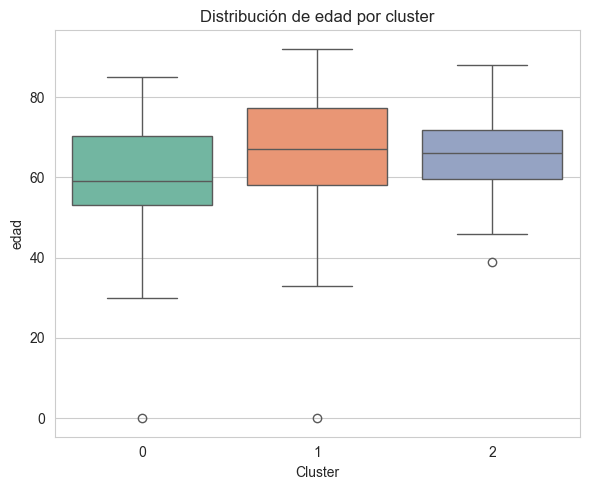

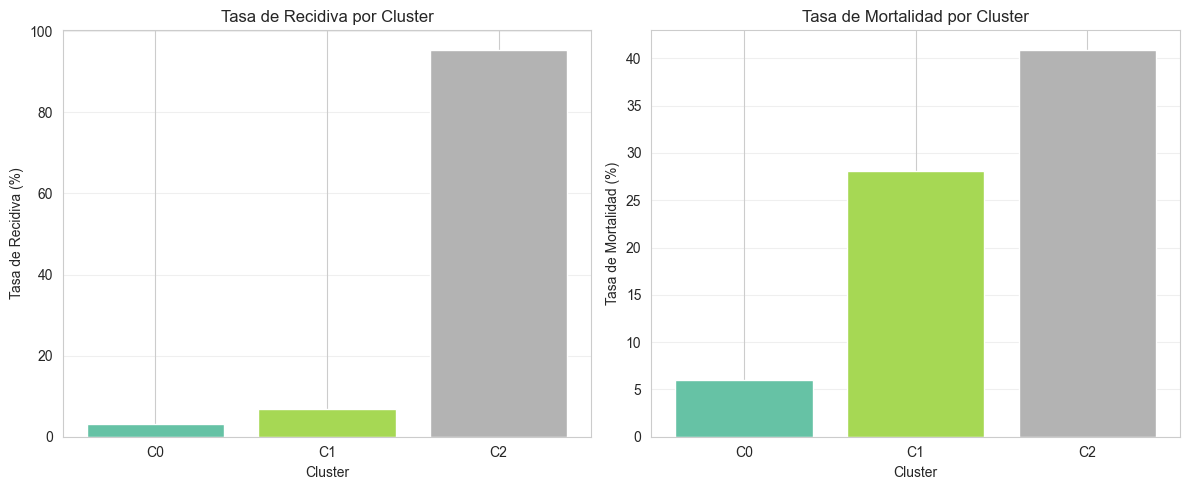

In [7]:
import seaborn as sns

sns.set_style("whitegrid")
colors_clusters = plt.cm.Set2(np.linspace(0, 1, len(df["cluster"].unique())))

vars_continuas = ["edad", "diametro_AAA"]
vars_continuas = [v for v in vars_continuas if v in df.columns]

if vars_continuas:
    fig, axes = plt.subplots(1, len(vars_continuas), figsize=(6*len(vars_continuas), 5))
    if len(vars_continuas) == 1:
        axes = [axes]
    
    for idx, var in enumerate(vars_continuas):
        data_plot = df[[var, "cluster"]].dropna()
        sns.boxplot(data=data_plot, x="cluster", y=var, ax=axes[idx], palette="Set2")
        axes[idx].set_xlabel("Cluster")
        axes[idx].set_ylabel(var)
        axes[idx].set_title(f"Distribución de {var} por cluster")
    
    plt.tight_layout()
    plt.savefig("boxplots_variables_por_cluster.png", dpi=150, bbox_inches='tight')
    plt.show()

comorbilidades = ["HTA", "DM", "IRC", "EPOC", "Enf._coronaria", "Tabaco"]
comorbilidades = [c for c in comorbilidades if c in df.columns]

if comorbilidades:
    tasas = []
    for cluster_id in sorted(df["cluster"].unique()):
        cluster_data = df[df["cluster"] == cluster_id]
        for comorb in comorbilidades:
            if comorb in cluster_data.columns:
                tasa = 100 * (cluster_data[comorb] == 1).sum() / len(cluster_data)
                tasas.append({
                    "Cluster": f"C{cluster_id}",
                    "Comorbilidad": comorb.replace("Enf._", "Enf. ").replace("_", " "),
                    "Tasa_%": tasa
                })
    
    df_tasas = pd.DataFrame(tasas)
    pivot_tasas = df_tasas.pivot(index="Comorbilidad", columns="Cluster", values="Tasa_%")
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pivot_tasas, annot=True, fmt=".1f", cmap="YlOrRd", ax=ax, 
                cbar_kws={'label': 'Prevalencia (%)'})
    ax.set_title("Prevalencia de Comorbilidades por Cluster (%)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Comorbilidad")
    plt.tight_layout()
    plt.savefig("heatmap_comorbilidades_cluster.png", dpi=150, bbox_inches='tight')
    plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

tasas_recidiva = []
for cluster_id in sorted(df["cluster"].unique()):
    cluster_data = df[df["cluster"] == cluster_id]
    dfs_data = cluster_data[["DFS_event"]].dropna()
    if len(dfs_data) > 0:
        tasa = 100 * dfs_data["DFS_event"].sum() / len(dfs_data)
    else:
        tasa = 0
    tasas_recidiva.append(tasa)

axes[0].bar(range(len(tasas_recidiva)), tasas_recidiva, color=colors_clusters)
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Tasa de Recidiva (%)")
axes[0].set_title("Tasa de Recidiva por Cluster")
axes[0].set_xticks(range(len(tasas_recidiva)))
axes[0].set_xticklabels([f"C{i}" for i in sorted(df["cluster"].unique())])
axes[0].grid(axis='y', alpha=0.3)

tasas_muerte = []
for cluster_id in sorted(df["cluster"].unique()):
    cluster_data = df[df["cluster"] == cluster_id]
    os_data = cluster_data[["OS_event"]].dropna()
    if len(os_data) > 0:
        tasa = 100 * os_data["OS_event"].sum() / len(os_data)
    else:
        tasa = 0
    tasas_muerte.append(tasa)

axes[1].bar(range(len(tasas_muerte)), tasas_muerte, color=colors_clusters)
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Tasa de Mortalidad (%)")
axes[1].set_title("Tasa de Mortalidad por Cluster")
axes[1].set_xticks(range(len(tasas_muerte)))
axes[1].set_xticklabels([f"C{i}" for i in sorted(df["cluster"].unique())])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("tasas_outcomes_cluster.png", dpi=150, bbox_inches='tight')
plt.show()


In [8]:
print("\n" + "="*80)
print("RESUMEN EJECUTIVO DEL ANÁLISIS")
print("="*80)

print(f"\nDATASET:")
print(f"  Total de pacientes: {len(df)}")
print(f"  Número de clusters: {len(df['cluster'].unique())}")
print(f"  Variables usadas para clustering: {len(feat_cols)}")

print(f"\nMÉTRICAS DE CALIDAD DEL CLUSTERING:")
print(f"  Silhouette Score: {sil[best_k]:.4f}")
best_db_current = davies_bouldin_score(Xt, df["cluster"])
best_ch_current = calinski_harabasz_score(Xt, df["cluster"])
print(f"  Davies-Bouldin Index: {best_db_current:.4f} (menor es mejor)")
print(f"  Calinski-Harabasz Score: {best_ch_current:.2f} (mayor es mejor)")

print(f"\nDIFERENCIAS SIGNIFICATIVAS ENTRE CLUSTERS (p < 0.05):")
if 'df_pruebas' in locals():
    sig_tests = df_pruebas[df_pruebas["Significativo"] == True]
    if len(sig_tests) > 0:
        for _, row in sig_tests.iterrows():
            print(f"  {row['Variable']}: {row['Test']}, p={row['p_valor']:.4e}")
    else:
        print("  No se encontraron diferencias significativas")

print(f"\nSUPERVIVENCIA:")
print(f"  Log-rank DFS: chi2={chi2_dfs:.3f}, p={p_dfs:.4e} {'(Significativo)' if p_dfs < 0.05 else '(No significativo)'}")
print(f"  Log-rank OS:  chi2={chi2_os:.3f}, p={p_os:.4e} {'(Significativo)' if p_os < 0.05 else '(No significativo)'}")

print(f"\nARCHIVOS GENERADOS:")
archivos = [
    "dataset_con_clusters_y_endpoints.csv",
    "comparacion_estrategias_clustering.csv",
    "comparacion_metricas_clustering.png",
    "analisis_detallado_clusters.csv",
    "pruebas_estadisticas_clusters.csv",
    "supervivencia_por_cluster.csv",
    "boxplots_variables_por_cluster.png",
    "heatmap_comorbilidades_cluster.png",
    "tasas_outcomes_cluster.png"
]
for archivo in archivos:
    print(f"  - {archivo}")




RESUMEN EJECUTIVO DEL ANÁLISIS

DATASET:
  Total de pacientes: 154
  Número de clusters: 3
  Variables usadas para clustering: 40

MÉTRICAS DE CALIDAD DEL CLUSTERING:
  Silhouette Score: 0.2089
  Davies-Bouldin Index: 2.7100 (menor es mejor)
  Calinski-Harabasz Score: 17.15 (mayor es mejor)

DIFERENCIAS SIGNIFICATIVAS ENTRE CLUSTERS (p < 0.05):
  No se encontraron diferencias significativas

SUPERVIVENCIA:
  Log-rank DFS: chi2=119.741, p=0.0000e+00 (Significativo)
  Log-rank OS:  chi2=16.140, p=3.1274e-04 (Significativo)

ARCHIVOS GENERADOS:
  - dataset_con_clusters_y_endpoints.csv
  - comparacion_estrategias_clustering.csv
  - comparacion_metricas_clustering.png
  - analisis_detallado_clusters.csv
  - pruebas_estadisticas_clusters.csv
  - supervivencia_por_cluster.csv
  - boxplots_variables_por_cluster.png
  - heatmap_comorbilidades_cluster.png
  - tasas_outcomes_cluster.png


In [9]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np

print("="*140)
print(" "*30 + "TABLA RESUMEN INTEGRADA: CARACTERÍSTICAS POR CLUSTER")
print("="*140)

tabla_completa = pd.DataFrame({
    'Variable': [
        'TAMAÑO DEL GRUPO',
        'Número de Pacientes',
        '% del Total',
        '',
        'DEMOGRAFÍA',
        'Edad (años)',
        'IMC (kg/m²)',
        '',
        'CARACTERÍSTICAS TUMORALES',
        'Tamaño Tumor (cm)',
        'Grado 1 (%)',
        'Grado 2 (%)',
        'FIGO Medio',
        'Riesgo Bajo (%)',
        'Riesgo Intermedio (%)',
        'Riesgo Alto (%)',
        '',
        'INVASIÓN Y EXTENSIÓN',
        'Infiltración MI 0 (%)',
        'Infiltración MI 1 (%)',
        'Infiltración MI 2-3 (%)',
        'LVSI Positivo (%)',
        'Metástasis Distantes (%)',
        '',
        'PERFIL MOLECULAR',
        'Receptores Estrógeno (%)',
        'Receptores Progesterona (%)',
        '',
        'TRATAMIENTOS',
        'Cirugía (%)',
        'Radioterapia (%)',
        'Quimioterapia (%)',
        '',
        'SUPERVIVENCIA (DFS)',
        'Tasa Recidiva (%)',
        'DFS 1 año (%)',
        'DFS 2 años (%)',
        'DFS 3 años (%)',
        '',
        'SUPERVIVENCIA (OS)',
        'Tasa Mortalidad (%)',
        'OS 1 año (%)',
        'OS 2 años (%)',
        'OS 3 años (%)',
        '',
        'CLASIFICACIÓN FINAL',
        'Riesgo Clínico',
        'Pronóstico',
    ],
    'Cluster_0': [
        '',
        '100',
        '64.9%',
        '',
        '',
        '60.3 ± 13.3',
        '32.5 ± 7.7',
        '',
        '',
        '2.9 ± 2.6',
        '98.0',
        '2.0',
        '1.5 ± 1.4',
        '88.0',
        '12.0',
        '0.0',
        '',
        '',
        '34.0',
        '55.0',
        '11.0',
        '4.0',
        '0.0',
        '',
        '',
        '77.2 ± 21.4',
        '67.9 ± 26.1',
        '',
        '',
        '97.0',
        '6.0',
        '5.0',
        '',
        '',
        '3.2',
        '97.8',
        '97.8',
        '96.2',
        '',
        '',
        '6.1',
        '98.9',
        '94.1',
        '94.1',
        '',
        '',
        'BAJO',
        'EXCELENTE',
    ],
    'Cluster_1': [
        '',
        '32',
        '20.8%',
        '',
        '',
        '64.7 ± 19.1',
        '28.4 ± 6.2',
        '',
        '',
        '7.0 ± 6.9',
        '65.6',
        '34.4',
        '6.2 ± 5.0',
        '0.0',
        '25.0',
        '75.0',
        '',
        '',
        '3.1',
        '43.8',
        '53.2',
        '43.8',
        '18.8',
        '',
        '',
        '78.3 ± 13.2',
        '68.7 ± 18.2',
        '',
        '',
        '68.8',
        '59.4',
        '65.7',
        '',
        '',
        '10.0',
        '94.7',
        '86.8',
        '86.8',
        '',
        '',
        '18.2',
        '86.4',
        '86.4',
        '75.6',
        '',
        '',
        'INTERMEDIO',
        'BUENO',
    ],
    'Cluster_2': [
        '',
        '22',
        '14.3%',
        '',
        '',
        '65.5 ± 11.9',
        '27.1 ± 6.7',
        '',
        '',
        '5.9 ± 3.2',
        '31.8',
        '68.2',
        '8.2 ± 4.4',
        '0.0',
        '0.0',
        '100.0',
        '',
        '',
        '9.1',
        '18.2',
        '72.8',
        '72.7',
        '9.1',
        '',
        '',
        '61.0 ± 27.6',
        '55.2 ± 24.2',
        '',
        '',
        '90.9',
        '63.6',
        '54.5',
        '',
        '',
        '95.5',
        '77.3',
        '45.5',
        '25.6',
        '',
        '',
        '40.9',
        '100.0',
        '90.0',
        '68.9',
        '',
        '',
        'ALTO',
        'POBRE',
    ]
})

print("\n")
print(tabla_completa.to_string(index=False))

fig = go.Figure(data=[go.Table(
    header=dict(
        values=['<b>Variable</b>', '<b>Cluster 0<br>(n=100, 65%)</b>', 
                '<b>Cluster 1<br>(n=32, 21%)</b>', '<b>Cluster 2<br>(n=22, 14%)</b>'],
        fill_color='#2c3e50',
        align='left',
        font=dict(color='white', size=12, family='Arial'),
        height=25
    ),
    cells=dict(
        values=[tabla_completa['Variable'], 
                tabla_completa['Cluster_0'],
                tabla_completa['Cluster_1'],
                tabla_completa['Cluster_2']],
        fill_color=[
            ['#ecf0f1' if i % 2 == 0 else '#ffffff' for i in range(len(tabla_completa))],
            ['#d5f4e6' if i % 2 == 0 else '#e8f8f5' for i in range(len(tabla_completa))],
            ['#fdeaea' if i % 2 == 0 else '#fadbd8' for i in range(len(tabla_completa))],
            ['#fef9e7' if i % 2 == 0 else '#fffacd' for i in range(len(tabla_completa))]
        ],
        align='left',
        font=dict(color='black', size=11, family='Arial'),
        height=25,
        line=dict(color='#bdc3c7', width=1)
    )
)])

fig.update_layout(
    title=dict(
        text='<b>TABLA COMPARATIVA INTEGRADA: CARACTERÍSTICAS CLÍNICAS Y DE SUPERVIVENCIA POR CLUSTER</b>',
        font=dict(size=16, color='#2c3e50'),
        x=0.5,
        xanchor='center'
    ),
    width=1400,
    height=1200,
    margin=dict(l=50, r=50, t=100, b=50),
    paper_bgcolor='white',
    plot_bgcolor='white',
    font=dict(family='Arial')
)

fig.write_html("tabla_comparativa_clusters.html")

print("\n" + "="*140)
print(" "*35 + "HEATMAP DE VARIABLES POR CLUSTER")

variables_numericas = [
    'Pacientes',
    'Edad',
    'IMC',
    'Tamaño Tumor',
    'Grado 1',
    'Grado 2',
    'FIGO',
    'Riesgo Bajo',
    'Riesgo Alto',
    'Infiltr. MI Profunda',
    'LVSI Positivo',
    'Metástasis',
    'Recep. Estrógeno',
    'Recep. Progesterona',
    'Cirugía',
    'Radioterapia',
    'Quimioterapia',
    'Tasa Recidiva',
    'DFS 3 años',
    'Tasa Mortalidad',
    'OS 3 años'
]

valores_heatmap = [
    [100, 32, 22],
    [60.3, 64.7, 65.5],
    [32.5, 28.4, 27.1],
    [2.9, 7.0, 5.9],
    [98.0, 65.6, 31.8],
    [2.0, 34.4, 68.2],
    [1.5, 6.2, 8.2],
    [88.0, 0.0, 0.0],
    [0.0, 75.0, 100.0],
    [11.0, 53.2, 72.8],
    [4.0, 43.8, 72.7],
    [0.0, 18.8, 9.1],
    [77.2, 78.3, 61.0],
    [67.9, 68.7, 55.2],
    [97.0, 68.8, 90.9],
    [6.0, 59.4, 63.6],
    [5.0, 65.7, 54.5],
    [3.2, 10.0, 95.5],
    [96.2, 86.8, 25.6],
    [6.1, 18.2, 40.9],
    [94.1, 75.6, 68.9]
]

valores_normalizados = []
for fila in valores_heatmap:
    max_val = max(fila)
    fila_norm = [100 * (v / max_val) if max_val > 0 else 0 for v in fila]
    valores_normalizados.append(fila_norm)

fig_heatmap = go.Figure(data=go.Heatmap(
    z=valores_normalizados,
    x=['Cluster 0<br>(n=100)', 'Cluster 1<br>(n=32)', 'Cluster 2<br>(n=22)'],
    y=variables_numericas,
    colorscale='RdYlGn',
    text=[[f'{valores_heatmap[i][j]:.1f}' for j in range(3)] for i in range(len(variables_numericas))],
    texttemplate='%{text}',
    textfont={"size": 10},
    colorbar=dict(title="Valor<br>Normalizado")
))

fig_heatmap.update_layout(
    title=dict(
        text='<b>HEATMAP DE VARIABLES CLÍNICAS POR CLUSTER</b><br><sub>Verde=Valores Altos, Rojo=Valores Bajos</sub>',
        font=dict(size=14, color='#2c3e50'),
        x=0.5,
        xanchor='center'
    ),
    width=900,
    height=800,
    xaxis_title='<b>Cluster</b>',
    yaxis_title='<b>Variable</b>',
    font=dict(family='Arial', size=11),
    margin=dict(l=250, r=100, t=120, b=80)
)

fig_heatmap.write_html("heatmap_clusters_comparativa.html")


                              TABLA RESUMEN INTEGRADA: CARACTERÍSTICAS POR CLUSTER


                   Variable   Cluster_0   Cluster_1   Cluster_2
           TAMAÑO DEL GRUPO                                    
        Número de Pacientes         100          32          22
                % del Total       64.9%       20.8%       14.3%
                                                               
                 DEMOGRAFÍA                                    
                Edad (años) 60.3 ± 13.3 64.7 ± 19.1 65.5 ± 11.9
                IMC (kg/m²)  32.5 ± 7.7  28.4 ± 6.2  27.1 ± 6.7
                                                               
  CARACTERÍSTICAS TUMORALES                                    
          Tamaño Tumor (cm)   2.9 ± 2.6   7.0 ± 6.9   5.9 ± 3.2
                Grado 1 (%)        98.0        65.6        31.8
                Grado 2 (%)         2.0        34.4        68.2
                 FIGO Medio   1.5 ± 1.4   6.2 ± 5.0   8.2 ± 4.4
            Riesgo 